In [16]:
import os
import random
import torch
import numpy as np
import torchvision.transforms as transforms
import pydicom
from scipy.ndimage.filters import median_filter
from lungmask import mask
import SimpleITK as sitk
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
import tensorflow as tf
from torch import nn, optim

C:\Users\Nimesha\AppData\Local\Temp\ipykernel_17052\2507163119.py:7: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


In [17]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def get_mask(filename, plot_mask=False, return_val=False):

    input_image = sitk.ReadImage(filename)
    mask_out = mask.apply(input_image)[0]  #default model is U-net(R231)

    if return_val:
        return mask_out

def preprocess_images(img,dicom_image):

    hu_image = transform_to_hu(dicom_image, img)
    filtered_image = median_filter(hu_image, size=(3, 3))
    return filtered_image

In [18]:
import torch.nn as nn
import torchvision.models as models


class VGG16Gray(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16Gray, self).__init__()
        vgg16 = models.vgg16(pretrained=pretrained)
        # Remove the last fully connected layer of VGG16
        self.features = nn.Sequential(*list(vgg16.features.children())[:-1])
        # Replace the input convolution layer to accept single channel grayscale images
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.features(x)
        
        x = x.view(x.size(0), -1)
        return x


In [19]:
class DICOMDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.img_labels = []
        self.root_dir = root_dir
        self.dcm_files = os.listdir(root_dir)

        for filename in os.listdir(root_dir):
            
            image_name = filename
            category = image_name[0]

            if category =='A' :
               label=1
            elif category =='B':
               label=2
            elif category =='G':  
               label=3 
            elif category =='E':
               label=4 
            else : label=5        
          
            self.img_labels.append((image_name,label))

    def __len__(self):
        # print(len(self.img_labels))
        return len(self.img_labels)

    def __getitem__(self, idx):

        dcm_file = self.dcm_files[idx]
   
        label_ch =dcm_file[0]
        if label_ch =='A' :
            label=1
        elif label_ch =='B':
            label=2
        elif label_ch =='G':  
            label=3 
        elif label_ch =='E':
            label=4  
        else : label=5
        dcm_path = os.path.join(self.root_dir, dcm_file)
        
        dicom_image= pydicom.dcmread(dcm_path)
        image = np.array(dicom_image.pixel_array)
        print(image.shape)

        cleaned_image = preprocess_images(image,dicom_image)
        masked_img=get_mask(dcm_path,plot_mask=True,return_val=True)
    
        mask_on_orginal = cleaned_image * masked_img
        mask_on_orginal = cv2.resize(mask_on_orginal, (224, 224))
       
        image = mask_on_orginal.astype('float32')
        image = np.expand_dims(image, axis=0)
       
        image = torch.from_numpy(image)

        return image, label

In [20]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        
        z_query = self.backbone.forward(query_images)
        
        
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)
        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        
        return scores

In [21]:
convolutional_network = VGG16Gray(pretrained=True)
model = PrototypicalNetworks(convolutional_network)
model.eval()


PrototypicalNetworks(
  (backbone): VGG16Gray(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpl

In [22]:
%run TaskSampler.ipynb

dataset = DICOMDataset(root_dir='../IMAGES/TEST_SET/', transform=None)


N_WAY = 4  # Number of classes in a task
N_SHOT = 4 # Number of images per class in the support set
N_QUERY = 2  # Number of images per class in the query set
N_EVALUATION_TASKS = 3

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
dataset.get_labels = lambda: [
    instance[1] for instance in dataset.img_labels
]

test_sampler = TaskSampler(
    dataset, n_way=N_WAY , n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    dataset,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [23]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))


model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{[example_class_ids[example_query_labels[i]]]} / {[example_class_ids[example_predicted_labels[i]]]}"
    )


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3004.52it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 3997.43it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.72it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1916.96it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5000.36it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4011.77it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4002.20it/s]


Ground Truth / Predicted
[1] / [1]
[1] / [1]
[2] / [3]
[2] / [2]
[3] / [3]
[3] / [3]
[4] / [4]
[4] / [4]


In [24]:
print(torch.cuda.is_available())

True


In [25]:
N_TRAINING_EPISODES = 3

train_set = DICOMDataset(root_dir='../IMAGES/TRAIN_SET/', transform=None)
train_set.get_labels = lambda: [ instance[1] for instance in train_set.img_labels]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [26]:
# Create a validation sampler and data loader

validation_set = DICOMDataset(root_dir='../IMAGES/VALIDATION_SET/', transform=None)
validation_set.get_labels = lambda: [ instance[1] for instance in validation_set.img_labels]
validation_sampler = TaskSampler(
    validation_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
validation_loader = DataLoader(
    validation_set,
    batch_sampler=validation_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=validation_sampler.episodic_collate_fn,
)

In [27]:
def sliding_average(lst, window_size):
    if window_size == 0:
        return 0.0
    return sum(lst[-window_size:]) / min(len(lst), window_size)


In [28]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize lists to store episode indices and accuracies
episode_indices = []
accuracies = []


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

log_update_frequency = 1
val_frequency = 1  # Validate every 5  training episodes
best_accuracy = 0.0

all_loss = []
model.train()

with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        
        all_loss.append(loss_value)
      
        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
        print("Episode Index")
        print(episode_index)
        # Validate the model
        if episode_index % val_frequency == 0:
           
            model.eval()
            with torch.no_grad():
                total_correct = 0
                total_examples = 0
                for (
                    support_images,
                    support_labels,
                    query_images,
                    query_labels,
                    _,
                ) in validation_loader:
                    classification_scores = model(
                        support_images, support_labels, query_images
                    )
                    predicted_labels = classification_scores.argmax(dim=-1)
                    total_correct += (predicted_labels == query_labels).sum().item()
                    total_examples += predicted_labels.shape[0]

                accuracy = total_correct / total_examples
                
                # Append episode index and accuracy to lists
                episode_indices.append(episode_index)
                accuracies.append(accuracy)
              
               
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    # You can save the model here if you want
                    print("best accuracy")
                    print(best_accuracy)

                print(f"Validation accuracy: {accuracy:.4f}")

            model.train()





  0%|          | 0/3 [00:00<?, ?it/s]

(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 3961.56it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1996.81it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1997.76it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5005.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1996.81it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1989.24it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 9995.96it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


  0%|          | 0/3 [00:19<?, ?it/s, loss=203]

Episode Index
0
(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3005.23it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 3972.82it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4999.17it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 10010.27it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4990.84it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2994.51it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3006.67it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1986.41it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5006.33it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1990.65it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2002.53it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 3996.48it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3001.65it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1994.44it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2003.97it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4997.98it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 10022.23it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1994.91it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5002.75it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4000.29it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3021.83it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3003.80it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1993.49it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


 33%|███▎      | 1/3 [01:02<02:04, 62.41s/it, loss=203]

best accuracy
0.9583333333333334
Validation accuracy: 0.9583
(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2003.49it/s]


(512, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 9995.96it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5001.55it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4000.29it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2011.66it/s]


(512, 512)


 33%|███▎      | 1/3 [01:22<02:04, 62.41s/it, loss=0]  

Episode Index
1
(512, 512)


100%|██████████| 10/10 [00:00<00:00, 9998.34it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4683.23it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1997.29it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2003.01it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2011.17it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4999.17it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3001.65it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4001.24it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5013.51it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5006.33it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2007.80it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5002.75it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 3993.62it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2991.66it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


 67%|██████▋   | 2/3 [02:04<01:02, 62.48s/it, loss=0]

Validation accuracy: 0.9167
(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2002.05it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4973.09it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2992.37it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2993.08it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4006.02it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 10000.72it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2001.58it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


 67%|██████▋   | 2/3 [02:24<01:02, 62.48s/it, loss=0]

Episode Index
2
(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3005.23it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 10005.50it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4001.24it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2993.79it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1982.19it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2995.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2009.25it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2995.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3000.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2002.05it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 4996.79it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 10005.50it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


(512, 512)


100%|██████████| 5/5 [00:00<00:00, 5000.36it/s]


(512, 512)


100%|██████████| 10/10 [00:00<00:00, 9981.68it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1994.91it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]


(512, 512)


100%|██████████| 3/3 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1995.39it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1994.44it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1996.34it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 2995.22it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3005.23it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


(512, 512)


100%|██████████| 4/4 [00:00<00:00, 4006.02it/s]


(512, 512)


100%|██████████| 2/2 [00:00<?, ?it/s]


(512, 512)


100%|██████████| 2/2 [00:00<00:00, 1998.24it/s]


(512, 512)


100%|██████████| 3/3 [03:07<00:00, 62.41s/it, loss=0]

Validation accuracy: 0.7500


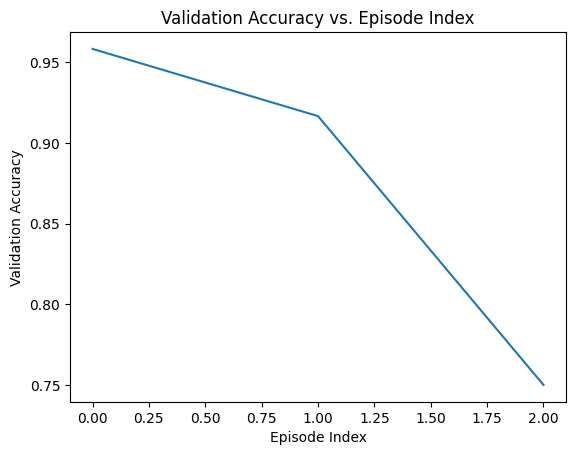

In [29]:
# Create a line plot of accuracy vs. episode index
plt.plot(episode_indices, accuracies)
plt.title("Validation Accuracy vs. Episode Index")
plt.xlabel("Episode Index")
plt.ylabel("Validation Accuracy")
plt.show()